In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from PIL import Image

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


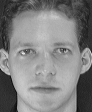

In [3]:
Image.open("att-database-of-faces/s1/1.pgm")

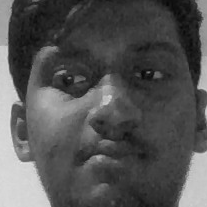

In [5]:
Image.open("att-database-of-faces/s40/2.pgm")

(112, 92)


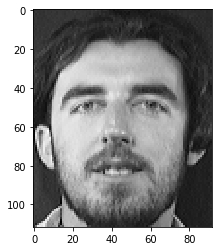

In [6]:
img = read_image('att-database-of-faces/s11/1.pgm')
print(img.shape)
plt.imshow(img, 'gray')

In [7]:


size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('att-database-of-faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('att-database-of-faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('att-database-of-faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = cv2.resize(img1[::size, ::size],(46, 56))
            img2 = cv2.resize(img2[::size, ::size],(46, 56))
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('att-database-of-faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('att-database-of-faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

#             img1 = img1[::size, ::size]
#             img2 = img2[::size, ::size]
            img1 = cv2.resize(img1[::size, ::size],(46, 56))
            img2 = cv2.resize(img2[::size, ::size],(46, 56))

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [8]:
X, Y = get_data(size, total_sample_size)
print(X.shape)
print(Y.shape)

(20000, 2, 1, 56, 46)
(20000, 1)


[1.]


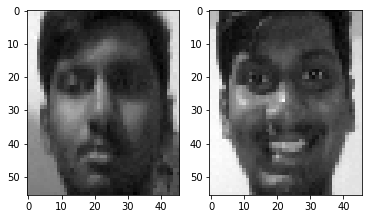

In [12]:
i = 9995
print(Y[i])

plt.subplot(1,2,1)
plt.imshow(X[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(X[i,1].reshape(56,46),'gray')

[1.]


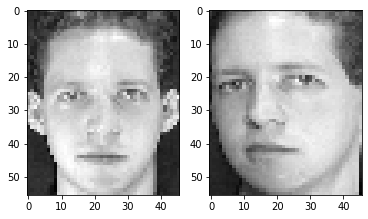

In [13]:
i = 0
print(Y[i])

plt.subplot(1,2,1)
plt.imshow(X[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(X[i,1].reshape(56,46),'gray')

[0.]


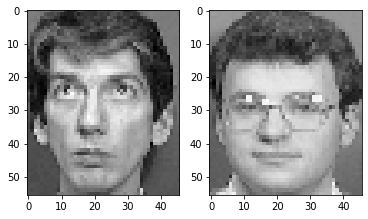

In [14]:
i = 12224
print(Y[i])

plt.subplot(1,2,1)
plt.imshow(X[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(X[i,1].reshape(56,46),'gray')

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [16]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], (kernel_size, kernel_size), input_shape=input_shape,
                          padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], (kernel_size, kernel_size), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [17]:
input_dim = x_train.shape[2:]
print(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
base_network.summary()

(1, 56, 46)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 54, 44)         60        
_________________________________________________________________
activation (Activation)      (None, 6, 54, 44)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 27, 22)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 27, 22)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 25, 20)        660       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 25, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 

In [18]:
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [19]:
print(feat_vecs_a.shape)
print(feat_vecs_b.shape)

(None, 50)
(None, 50)


In [20]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [21]:
epochs = 13
rms = RMSprop()

model = Model(inputs=[img_a, img_b], outputs=distance)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 56, 46)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 56, 46)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           191618      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [22]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [23]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25,
          batch_size=128, verbose=2, epochs=epochs)

Train on 12000 samples, validate on 4000 samples
Epoch 1/13
12000/12000 - 32s - loss: 0.2342 - val_loss: 0.2459
Epoch 2/13
12000/12000 - 28s - loss: 0.1447 - val_loss: 0.2326
Epoch 3/13
12000/12000 - 28s - loss: 0.1110 - val_loss: 0.1200
Epoch 4/13
12000/12000 - 27s - loss: 0.0851 - val_loss: 0.0871
Epoch 5/13
12000/12000 - 27s - loss: 0.0688 - val_loss: 0.0717
Epoch 6/13
12000/12000 - 27s - loss: 0.0589 - val_loss: 0.0421
Epoch 7/13
12000/12000 - 27s - loss: 0.0517 - val_loss: 0.0423
Epoch 8/13
12000/12000 - 27s - loss: 0.0461 - val_loss: 0.0380
Epoch 9/13
12000/12000 - 27s - loss: 0.0422 - val_loss: 0.0348
Epoch 10/13
12000/12000 - 27s - loss: 0.0378 - val_loss: 0.0330
Epoch 11/13
12000/12000 - 28s - loss: 0.0349 - val_loss: 0.0331
Epoch 12/13
12000/12000 - 29s - loss: 0.0322 - val_loss: 0.0267
Epoch 13/13
12000/12000 - 27s - loss: 0.0305 - val_loss: 0.0225


In [24]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [25]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

compute_accuracy(pred, y_test)

0.9604147031102733

[1.]


array([1.4197928], dtype=float32)

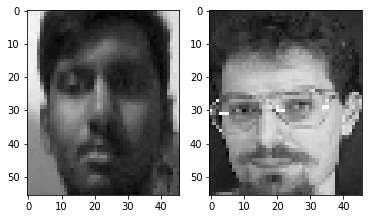

In [62]:
i = 28
print(abs(y_test[i]-1))

plt.subplot(1,2,1)
plt.imshow(x_test[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(x_test[i,1].reshape(56,46),'gray')

#pred = model.predict([x_test[i, 0].reshape(1,1,56,46), x_test[i, 1].reshape(1,1,56,46)])
pred[i]

[1.]


array([1.3694085], dtype=float32)

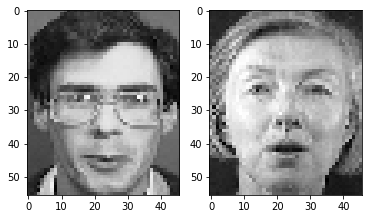

In [45]:
i = 1043
print(abs(y_test[i]-1))

plt.subplot(1,2,1)
plt.imshow(x_test[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(x_test[i,1].reshape(56,46),'gray')

#pred = model.predict([x_test[i, 0].reshape(1,1,56,46), x_test[i, 1].reshape(1,1,56,46)])
pred[i]

[1.]


array([1.2687149], dtype=float32)

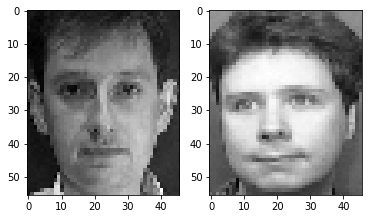

In [134]:
i = 1434
print(abs(y_test[i]-1))

plt.subplot(1,2,1)
plt.imshow(x_test[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(x_test[i,1].reshape(56,46),'gray')

#pred = model.predict([x_test[i, 0].reshape(1,1,56,46), x_test[i, 1].reshape(1,1,56,46)])
pred[i]

[1.]


array([0.98246354], dtype=float32)

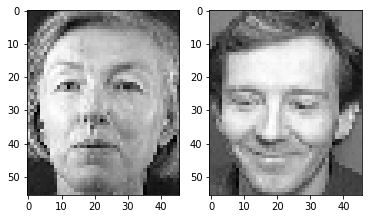

In [137]:
i = 3
print(abs(y_test[i]-1))

plt.subplot(1,2,1)
plt.imshow(x_test[i,0].reshape(56,46),'gray')

plt.subplot(1,2,2)
plt.imshow(x_test[i,1].reshape(56,46),'gray')

#pred = model.predict([x_test[i, 0].reshape(1,1,56,46), x_test[i, 1].reshape(1,1,56,46)])
pred[i]

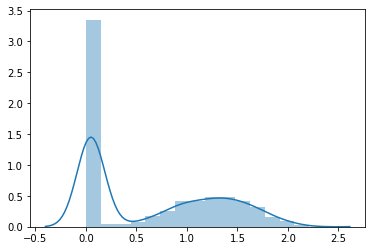

In [122]:
sns.distplot(pred)

In [138]:
# serialize model to JSON
model_json = model.to_json()
with open("model_siamese.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_siamese.h5")
print("Saved model to disk")

Saved model to disk
